<a href="https://colab.research.google.com/github/1900690/analog-meter-reading/blob/main/analog_meter_reading_webUI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

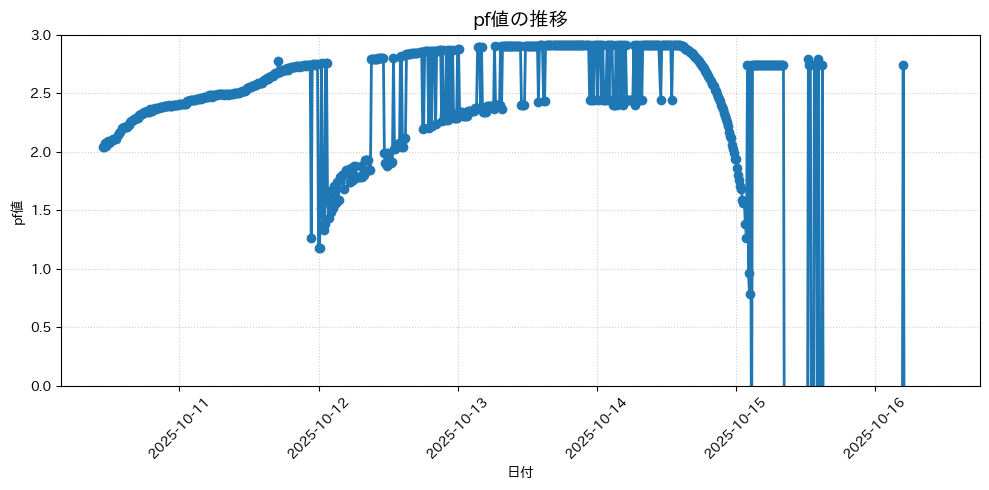


--- エクスポート ---


In [1]:
#@title スプレッドシート読み込み・グラフ表示（画像保存修正版）
#@markdown スプレッドシートのＵＲＬとシートの名前を入力して実行してください

!pip install japanize-matplotlib > /dev/null 2>&1

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import gspread
import ipywidgets as widgets
import os
from google.colab import auth, files
from google.auth import default
from IPython.display import display

# フォーム設定
spreadsheet_url = "https://docs.google.com/spreadsheets/d/14mMxlB6O42vG6AzgwruYaRt7Er_H7JBrb5QT4BzA32Y/edit?usp=drivesdk" #@param {type:"string"}
sheet_name = "log" #@param {type:"string"}

# 一時保存用のファイル名
TEMP_IMG = "graph_output.png"
TEMP_CSV = "data_output.csv"

def download_csv(b):
    if os.path.exists(TEMP_CSV):
        files.download(TEMP_CSV)
    else:
        print("CSVファイルが見つかりません。先にデータを読み込んでください。")

def download_image(b):
    if os.path.exists(TEMP_IMG):
        files.download(TEMP_IMG)
    else:
        print("画像ファイルが見つかりません。先にグラフを表示してください。")

# ボタンの作成
btn_csv = widgets.Button(description="CSVをダウンロード", button_style='success', icon='download')
btn_img = widgets.Button(description="グラフ画像を保存", button_style='info', icon='image')

btn_csv.on_click(download_csv)
btn_img.on_click(download_image)

def main():
    if not spreadsheet_url:
        print("💡 スプレッドシートのURLを入力して実行してください。")
        return

    try:
        # 認証
        auth.authenticate_user()
        creds, _ = default()
        gc = gspread.authorize(creds)

        # データ取得
        sh = gc.open_by_url(spreadsheet_url)
        worksheet = sh.worksheet(sheet_name)
        data = worksheet.get_all_records()
        df = pd.DataFrame(data)

        if df.empty:
            print("❌ データが空です。")
            return

        # 前処理
        cols = df.columns
        date_col, pf_col = cols[0], cols[1]
        df[date_col] = pd.to_datetime(df[date_col])
        df[pf_col] = pd.to_numeric(df[pf_col], errors='coerce')
        df = df.dropna(subset=[date_col, pf_col]).sort_values(by=date_col)

        # CSVとして一時保存
        df.to_csv(TEMP_CSV, index=False, encoding='utf-8-sig')

        # グラフ描画
        fig = plt.figure(figsize=(10, 5))
        plt.plot(df[date_col], df[pf_col], marker='o', color='#1f77b4', linewidth=2)

        plt.ylim(0, 3)
        plt.title(f'pf値の推移', fontsize=14)
        plt.xlabel('日付')
        plt.ylabel('pf値')
        plt.grid(True, linestyle=':', alpha=0.6)
        plt.xticks(rotation=45)
        plt.tight_layout()

        # --- ここがポイント：表示前に保存する ---
        plt.savefig(TEMP_IMG, bbox_inches='tight')

        # グラフ表示
        plt.show()

        # ボタンを表示
        print("\n--- エクスポート ---")
        display(widgets.HBox([btn_csv, btn_img]))

    except Exception as e:
        print(f"⚠️ エラー: {e}")

main()